# Réseaux de classification d'images (6 classes)

In [11]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import load_model
from keras import backend as K

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import numpy as np
from matplotlib import pyplot as plt

## Chargement du jeu de données

In [12]:
batchSize = 16
imgWidth, imgHeight = 80, 120

path = ""
datagen = ImageDataGenerator(
  rescale=1.0/255,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

data_train = datagen.flow_from_directory('data/ICN-6C-data/train', batch_size=batchSize, target_size=(imgWidth, imgHeight))
data_validation = datagen.flow_from_directory('data/ICN-6C-data/validation', batch_size=batchSize, target_size=(imgWidth, imgHeight))

nbTrainSamples = data_train.samples
nbValidationSamples = data_validation.samples

Found 300 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


### Extraction des classes

In [13]:
print(data_train.class_indices)
print(data_validation.class_indices)

{'art_antiques': 0, 'obj_aviation': 1, 'obj_cards': 2, 'obj_dish': 3, 'pet_cat': 4, 'sc_forests': 5}
{'art_antiques': 0, 'obj_aviation': 1, 'obj_cards': 2, 'obj_dish': 3, 'pet_cat': 4, 'sc_forests': 5}


## Mise en place d'un modèle (convnet) multi-classe

In [31]:
nbClasses = len(data_train.class_indices)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(imgWidth, imgHeight, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # Couche de conversion des features (de base sur 3 dimensions) en 1 dimensions (la classe)
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nbClasses))
model.add(Activation('softmax'))

# Utilisation de la fonction de coût d'erreur "binary_crossentropy" -> chaque sortie est vraie ou fausse (une sortie par classe).
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Entrainement du modèle

In [32]:
history = model.fit_generator(
        data_train,
        steps_per_epoch=nbTrainSamples // batchSize,
        epochs=50,
        validation_data=data_validation,
        validation_steps=nbValidationSamples // batchSize
)

# Sauvegarde du modèle
model.save("models/ICN-6C")

/nix/store/4g2wq9q5638ffbc1ikx38gqhlp3z94wp-python3-3.8.7-env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
18/18 [==============================] - 3s 121ms/step - loss: 1.8202 - accuracy: 0.1741 - val_loss: 1.6158 - val_accuracy: 0.4375
Epoch 2/50
18/18 [==============================] - 2s 104ms/step - loss: 1.5331 - accuracy: 0.4308 - val_loss: 1.1879 - val_accuracy: 0.5625
Epoch 3/50
18/18 [==============================] - 2s 119ms/step - loss: 1.3244 - accuracy: 0.4989 - val_loss: 0.9670 - val_accuracy: 0.7292
Epoch 4/50
18/18 [==============================] - 2s 98ms/step - loss: 1.1124 - accuracy: 0.6067 - val_loss: 0.9010 - val_accuracy: 0.6875
Epoch 5/50
18/18 [==============================] - 2s 97ms/step - loss: 0.9950 - accuracy: 0.6330 - val_loss: 0.5736 - val_accuracy: 0.8125
Epoch 6/50
18/18 [==============================] - 2s 99ms/step - loss: 0.7997 - accuracy: 0.6975 - val_loss: 1.0001 - val_accuracy: 0.6458
Epoch 7/50
18/18 [==============================] - 2s 113ms/step - loss: 0.8247 - accuracy: 0.7231 - val_loss: 0.6618 - val_accuracy: 0.8542
Epoch 8/5

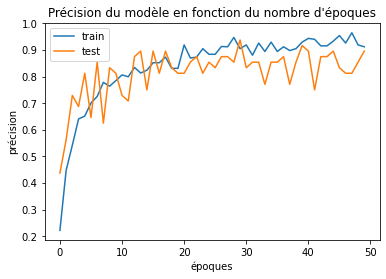

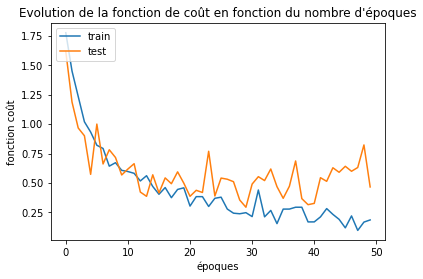

In [33]:
# Historique de la précision
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Précision du modèle en fonction du nombre d'époques")
plt.ylabel('précision')
plt.xlabel('époques')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Historique de la fonction de coût
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Evolution de la fonction de coût en fonction du nombre d'époques")
plt.ylabel('fonction coût')
plt.xlabel('époques')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Test du modèle

### Restauration du modèle

In [35]:
# Utile dans le cas ou on réutilise le modèle plus tard
model = load_model("models/ICN-6C")

### Génération de la matrice de confusion

In [36]:
test_datagen = ImageDataGenerator()
data_test = test_datagen.flow_from_directory('data/ICN-6C-data/test', target_size=(imgWidth, imgHeight), shuffle=False)

predictions = model.predict(data_test)
pred_labels = list(np.argmax(predictions, axis=-1))
true_labels = data_test.classes

cm = confusion_matrix(true_labels, pred_labels)
cm

Found 240 images belonging to 6 classes.


array([[31,  2,  0,  7,  0,  0],
       [ 0, 30,  5,  4,  0,  1],
       [ 0,  0, 40,  0,  0,  0],
       [ 0,  0,  1, 39,  0,  0],
       [ 1,  0, 11,  0, 28,  0],
       [ 0,  0, 11,  0,  0, 29]])

### Calcule de la précision

In [37]:
totalSuccess = accuracy_score(true_labels, pred_labels, normalize=False)
totalPredictions = data_test.samples

accuracy = totalSuccess / totalPredictions * 100

print("Résultat : " + str(totalSuccess) + "/" + str(totalPredictions) + " ("+ str(accuracy) + "%)")

Résultat : 197/240 (82.08333333333333%)


## Application - tri d'images

In [10]:
import os
import shutil

class_indices = data_train.class_indices
class_list = list(class_indices)

current_path = os.getcwd()
sorted_path = os.path.join(current_path, "application/sorted/")
unsorted_path = os.path.join(current_path, "application/unsorted")

# Suppression des anciennes utilisation
shutil.rmtree(sorted_path)

def get_class_dir(clazz):
    return os.path.join(sorted_path, clazz)

def predict_image_class(image_path):
    # Chargement de l'image
    img = load_img(image_path, target_size=(80, 120))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis = 0)

    # Prédiction de la classe
    return model.predict(img_array)

def extract_class_from_predict(predict):
    pass
    
    
# 1. Créer un sous-dossier pour chaque classe connues de mon modèle
for key in class_indices:
    # Création d'un dossier par classe
    path =  get_class_dir(key)
    os.makedirs(path)


# 2. Parcourir les images non-triées (dans un dossier unsorted)
for filename in os.listdir(unsorted_path):
    # On vérifie que c'est bien une image (jpg)
    if filename.endswith(".jpg"):
        file_path = os.path.join(unsorted_path, filename)
        # 3. Charger chaque image et demander au modèle de prédire la classe
        # On récupère seulement la meilleure prédiction
        top_predict = ((-predict_image_class(file_path)).argsort())[0][:1]
        # print(top_predict[0])
        img_class = class_list[top_predict[0]]
        # print(img_class)
        class_dir = get_class_dir(img_class)
        # 4. En fonction de la classe prédite déplacer l’image dans le sous-dossier correspondant.
        shutil.move(file_path, class_dir)

print("DONE")

DONE
